# AutoFormalism with GPT Results

We attempt to reproduce the in-context results of the paper [Autoformalism with LLMS](http://arxiv.org/abs/2205.12615).  The idea is to prompt an LLM to translate mathematical statements in to a full formal logical language. The paper chooses to translate to the proof assistant language [Isabelle](https://isabelle.in.tum.de/).  The LLM's used in the paper were [PALM](https://ai.google/discover/palm2/) and [Codex](https://openai.com/blog/openai-codex) but in this notebook we use GPT-3 and GPT-4. We ran a script external to this notebook to generate responses and we use this notebook to load data and generate results.

In [1]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from openai.types.chat import ChatCompletion
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction


from autoformalism_with_llms.dataset import MiniF2FMATH
from autoformalism_with_llms import prompt


In [2]:
class MODELS:
    gpt_3_1106 = "gpt-3.5-turbo-1106"
    gpt_3_0125 = "gpt-3.5-turbo-0125"
    gpt_4_0613 = "gpt-4-0613"
    gpt_4_1106 = "gpt-4-1106-preview"
    gpt_4_0125 = "gpt-4-0125-preview"
    gpt_4_0409 = "gpt-4-turbo-2024-04-09"


class ORDER:
    """Used to ensure plots are in the same order"""
    models= [
        MODELS.gpt_3_1106,
        MODELS.gpt_3_0125,
        MODELS.gpt_4_0613,
        MODELS.gpt_4_1106,
        MODELS.gpt_4_0125,
        MODELS.gpt_4_0409,
    ]

----
## Load Data
We previously ran `main.sh` which iterative executes `run_experiment.py` which is a re-implementation of the 10-shot autoformalism experiment as described in the paper.  The LLM responses are saved to disk, along with some metadata, so we no load this into memory.

In [3]:
def load_results(log_dir: str | Path)->list:
    """Create list of results.

    Args:
        log_dir (str | Path): The the results are saved into.

    Returns:
        (list): A list of dictionaries containing the chat completion and 
            the Math question.
    """
    files = Path(log_dir).rglob("*.json")
    results = []
    dataset = None 
    for fname in files:
        with open(fname, 'r') as f:
            data = json.load(f)
        metadata = data.pop('metadata')
        subject, qid = metadata['subject'], metadata['question_number']
        if dataset is None:
            dataset = MiniF2FMATH().get_subject(subject)
        completion = ChatCompletion(**data).choices[0].message.content
        question = dataset.get_question(qid)
        results.append({"completion":completion, "question":question, 'metadata':metadata})
    return results



def remove_spaces_around_operators(math:str)->str:
    """Removes spaces around +,-,*,/,= in an Isabelle string.

    We don't want our translation results to be thrown off by the arbitrary
    choice of whether to put spaces around operators.  Even in some target strings
    there are a mixed use of spaces.  This function removes all spaces around the 
    operator.  Note that also reduces BLEU scores since there are less tokens for 
    matching.

    Args:
        math (str): An Isabelle formal statement.

    Returns:
        The statement where the spaces around operators is removed.
    """
    return re.sub(r" *([\*\+\-\/=]) *", r"\1", math)


def remove_hypothesis_name(math:str)->str:
    """Removes named hypothesis like (e.g. `h0:`, `h1:`)

    The hypothesis in Isabelle can be named so they can be explicitly 
    referred to.  We want to check BLEU scores after normalizing the statements
    by removing these arbitrary names to get a sense of how well the model 
    translated the core of the statement without having the scores thrown off
    by these hypothesis names.
    """
    x= re.sub(r"h[0-9]\s*:", "", math, re.MULTILINE)
    return re.sub(r" +", " ", x)  # remove extra spaces we may have created.
    

# Some sanity checks for our preprocessing functions
def test_remove_spaces_around():
    """Simple test that the regex is doing what we think"""
    ops = list("+*-/=")
    for op in ops:
        math = f"space 3 {op} x around"
        actual = remove_spaces_around_operators(math)
        expected = f"space 3{op}x around"
        assert actual == expected, f"OP:{op} | {actual}!={expected}"

def remove_hypothesis_name_removes_name():
    math = "theorem \nmy hyp h0 : is"
    actual = remove_hypothesis_name(math)
    expected = "theorem \nmy hyp is"
    assert actual==expected, f"{actual}!={expected}"

Sanity check our preprocessing functions.

In [4]:
test_remove_spaces_around()
remove_hypothesis_name_removes_name()
print("All tests passed")

All tests passed


Now onto calculating BLEU scores, which roughly measure how well our LLM "translated" from natural language to Isabelle.

In [5]:
def calculate_bleu(results:list[dict], normalize:bool=True, smoothing_method:str="method4"):
    """Calculate BLEU scores over the entire corpus of results.

    Args:
        results (list): A list of dictionaries containing the chat completion and 
            the Math question.
        normalize (bool): Whether to normalize the strings before calculating the BLEU score.
        smoothing_method (str): The smoothing method to use for the BLEU score. 
            Default is "method4"
    """
    smooth = getattr(SmoothingFunction(), smoothing_method)
    
    references = []
    hypothesis = []
    for d in results:
        x = d['completion']
        y = prompt.get_formal_language_message(d['question'])['content']
        if normalize:
            x = _normalize(x)
            y = _normalize(y)
        x = x.split()
        y = y.split()
        references.append([x])
        hypothesis.append(y)
        
    
    bleu = corpus_bleu(references, hypothesis, smoothing_function=smooth)
    return bleu


def calculate_sentence_bleu(results:list, normalize:bool=True, smoothing_method:str="method4"):
    """Calculates the blue score for each sentence in the results

    This returns a list of scores, a list of pairs of (y_true, y_pred), and list of question ids.
    The data returned by this function can be used to figure out how many sentences have perfect 
    translations and to identify them directly.

    Args:
        results (list): A list of dictionaries containing the chat completion and 
            the Math question.
        normalize (bool): Whether to normalize the strings before calculating the BLEU score.
        smoothing_method (str): The smoothing method to use for the BLEU score. 
            Default is "method4"
    """
    smooth = getattr(SmoothingFunction(), smoothing_method)
    scores = []
    pairs = []
    ids = []

    for d in results:
        x = d['completion']
        y = prompt.get_formal_language_message(d['question'])['content']
        if normalize:
            x = _normalize(x)
            y = _normalize(y)
        x = x.split()
        y = y.split()
        pairs.append((x,y))
        ids.append(d['question'].question_number)
        scores.append(sentence_bleu([x],y, smoothing_function=smooth))
    
    return scores, pairs, ids

def _normalize(x): 
    x = remove_spaces_around_operators(x)
    x = remove_hypothesis_name(x)
    return x

Start by loading the algebra and number theory datasets, and the results for each GPT version

In [6]:
algebra_data = MiniF2FMATH().get_subject("algebra")
numtheory_data = MiniF2FMATH().get_subject("numbertheory")



alg = {}
num = {}
for model in ORDER.models:
    alg[model] = load_results(f"artifacts/{model}/algebra")
    num[model] = load_results(f"artifacts/{model}/numbertheory")

Now calculate the bleu scores for each GPT model on each dataset.

In [7]:
alg_bleu = {model: calculate_bleu(alg[model], normalize=False) for model in ORDER.models}
num_bleu = {model: calculate_bleu(num[model], normalize=False) for model in ORDER.models}

Finally, let's plot the results.

In [8]:
def plot_bleu(scores:list, labels:list, ax=None):
    """Simple bar plot for blue scores."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    assert len(scores) == len(labels), "Need a label for each set of scores"
    ax.grid(axis='x', alpha=0.3, zorder=0)
    sns.barplot(y=labels, x=scores, ax=ax, zorder=2)
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Average BLEU Score")
    ax.set_xlabel("BLEU Score")
    return fig, ax
        

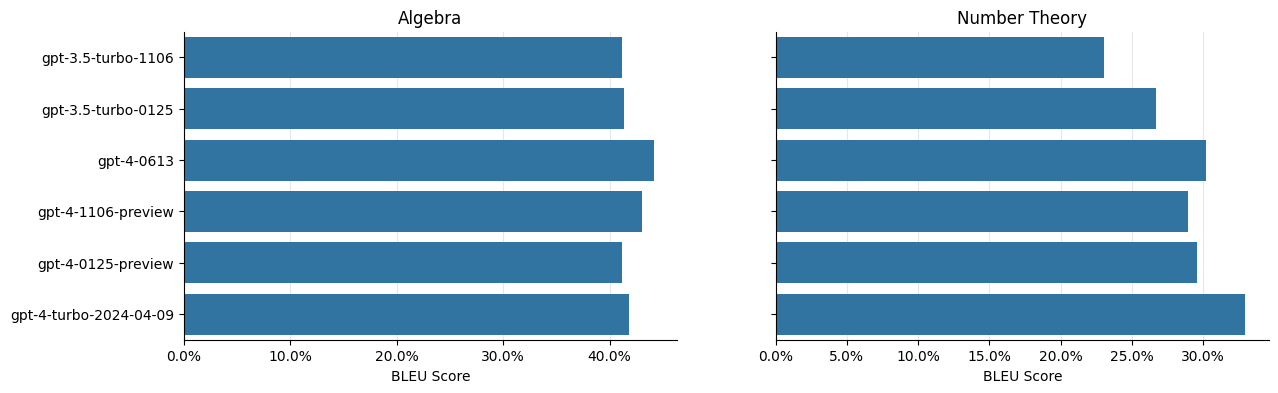

In [9]:
fig, axes = plt.subplots(1,2, figsize=(14,4), sharey=True)

alg_scores, alg_labels = list(alg_bleu.values()), list(alg_bleu.keys())
num_scores, num_labels = list(num_bleu.values()), list(num_bleu.keys())
_ = plot_bleu(alg_scores, alg_labels, ax=axes[0])
_ = plot_bleu(num_scores, num_labels, ax=axes[1])
axes[0].set_title("Algebra")
axes[1].set_title("Number Theory")


for ax in axes:
    ax.grid(axis="x", alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



The figure above shows the BLEU scores for each GPT model on each dataset.  Note these scores are well below the best scores reported in the paper.  For example, the Codex model obtains a BLEU of 57% on the algebra dataset.

### Repeat with normalization

In [10]:
alg_bleu_norm = {model: calculate_bleu(alg[model], normalize=True) for model in ORDER.models}
num_bleu_norm = {model: calculate_bleu(num[model], normalize=True) for model in ORDER.models}

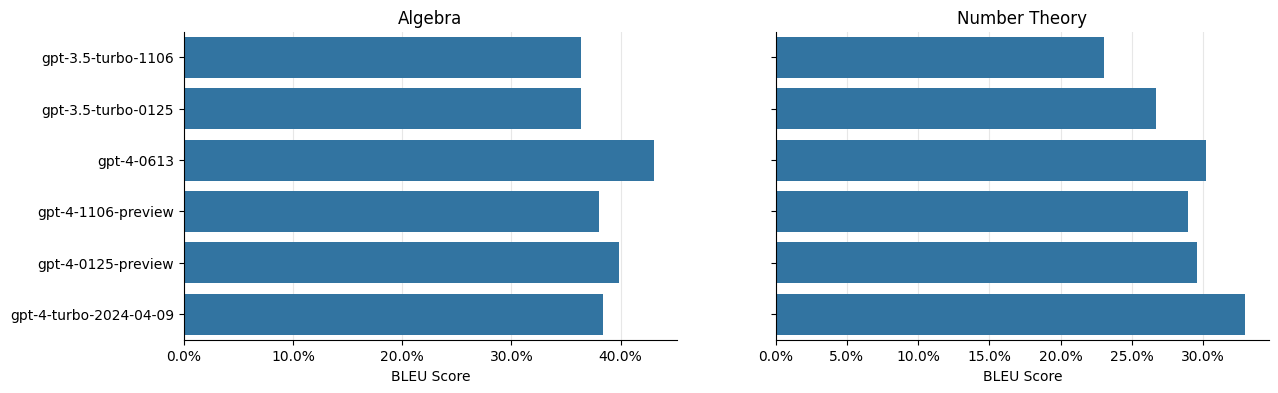

In [11]:
fig, axes = plt.subplots(1,2, figsize=(14,4), sharey=True)

alg_scores, alg_labels = list(alg_bleu_norm.values()), list(alg_bleu_norm.keys())
num_scores, num_labels = list(num_bleu.values()), list(num_bleu.keys())
_ = plot_bleu(alg_scores, alg_labels, ax=axes[0])
_ = plot_bleu(num_scores, num_labels, ax=axes[1])
axes[0].set_title("Algebra")
axes[1].set_title("Number Theory")


for ax in axes:
    ax.grid(axis="x", alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

This plot is similar to previous plots but now we normalize the text by removing spaces around operators and removing named hypothesis.  For example "3 + x" -> "3+x".  This normalization makes it easier to get a perfect match but also genearlly lowers the BLEU score since there are few tokens to match.

Similar to the previous plot but now with the Number Theory dataset.

----
## Checking the Prompt
The results in the previous section are worse than the results reported in the original paper, where the Codex model achieved a BLEU score of ~57%.  Let's sanity check out prompt.

In [12]:
from run_experiment import make_fewshot_prompt, FEWSHOTIDS

for d in make_fewshot_prompt(algebra_data, FEWSHOTIDS.algebra):
    print(f"{d['role']}: {d['content']}\n")

system: Translate the following natural language math problem to the Isabelle theorem proving language.  Do not provide a proof of the statement. Use dilligence when translating the problem and make certain you capture all the necessary assumptions as hypotheses.

user: Simplify $\left( \frac{4}{x} \right)^{-1} \left( \frac{3x^3}{x} \right)^2 \left( \frac{1}{2x} \right)^{-3}$. The final answer is $18x^8$.

assistant: theorem
  fixes x :: real
  assumes h0 : "x \<noteq> 0"
  shows "1/(4/x) * ((3*x^3)/x)^2 * (1/(1 / (2 * x)))^3 = 18 * x^8"

user: For integers $n$, let \[f(n) = \left\{
\begin{array}{cl}
n^2 & \text{ if }n\text{ is odd}, \\
n^2 - 4n - 1 & \text{ if }n\text{ is even}.
\end{array}
\right.\]Find $f(f(f(f(f(4)))))$. The final answer is $1$.

assistant: theorem
  fixes f :: "int \<Rightarrow> int"
  assumes "\<forall>n. odd n \<longrightarrow> f n = n^2"
    and "\<forall> n. even n \<longrightarrow> f n = n^2 - 4*n -1" 
  shows "f 4 = -1"

user: The volume of a cone is given b

Note that the prompt we are using does few-shot learning in the form of "user/assistant" pairs where the users inputs a natural langauge math statement and the LLM translates it to Isabella.  The prompt used in the paper is a single prompt and one of the main differences is the repeated reminder (in each example) of the task to translate to Isabella.  However, this doesn't seem like a huge limitation since the LLM is clearly outputting Isabella code in its responses so its faithfully following the task.

By inspection we appear to be using the exact same few shot examples in the exact same order.

----
## Inspect examples

We now inspect some examples to see what types of translations the model tends to get right and wrong.

In [13]:
def get_good_examples(blue_scores, threshold=0.7, model=MODELS.gpt_4_0613):
    scores, pairs, ids = blue_scores[model]
    return [pair for (score, pair) in zip(scores,pairs) if score > threshold], [id for (score, id) in zip(scores, ids) if score > threshold]

def get_bad_examples(blue_scores, threshold=0.2, model=MODELS.gpt_4_0613):
    scores, pairs, ids = blue_scores[model]
    return [pair for (score, pair) in zip(scores,pairs) if score < threshold], [id for (score, id) in zip(scores, ids) if score < threshold]

alg_sentence_bleu = {model: calculate_sentence_bleu(alg[model], normalize=False) for model in ORDER.models}
num_sentence_bleu = {model: calculate_sentence_bleu(num[model], normalize=False) for model in ORDER.models}

alg_good, alg_good_id = get_good_examples(alg_sentence_bleu)
alg_bad, alg_bad_id = get_bad_examples(alg_sentence_bleu)
num_good, num_good_id = get_good_examples(num_sentence_bleu)
num_bad, num_bad_id = get_bad_examples(num_sentence_bleu)

In [14]:
examples = [0,1,2,3,4,5]
print("Algebra Examples\n----------------")
for i in examples:
    print(f"Good Example {i}")
    question = algebra_data.get_question(alg_good_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(alg_good[i][0])}\n{' '.join(alg_good[i][1])}\n")
    print(f"Bad Example {i}")
    question = algebra_data.get_question(alg_bad_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(alg_bad[i][0])}\n{' '.join(alg_bad[i][1])}\n")

Algebra Examples
----------------
Good Example 0
Five plus $500\%$ of $10$ is the same as $110\%$ of what number? The final answer is $50$.
theorem fixes x :: real assumes "5 + 500 / 100 * 10 = 110 / 100 * x" shows "x = 50"
theorem fixes x :: real assumes "5 + 500 / 100 * 10 = 110 / 100 * x" shows "x = 50"

Bad Example 0
If two (positive) prime numbers are roots of the equation $x^2-12x+k=0$, what is the value of $k$? The final answer is $35$.
theorem fixes k :: real assumes "\<forall> x. prime x \<longrightarrow> x^2 - 12 * x + k = 0" shows "k = 35"
theorem fixes m n :: nat and k :: real and f :: "real \<Rightarrow> real" assumes h0 : "prime m" and h1 : "prime n" and h2 : "m \<noteq> n" and h3 : "\<And>x. f x = x^2 - 12*x + k" and h4 : "f m = 0" and h5 : "f n = 0" shows "k = 35"

Good Example 1
Assuming $x\ne0$, simplify $\frac{12}{x \cdot x} \cdot \frac{x^4}{14x}\cdot \frac{35}{3x}$. The final answer is $10$.
theorem fixes x :: real assumes h0 : "x \<noteq> 0" shows "12 / (x * x) * (

In [15]:
examples = [0,1,2,3,4]
print("Number Theory Examples\n----------------------")
for i in examples:
    print(f"Good Example {i}")
    question = numtheory_data.get_question(num_good_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(num_good[i][0])}\n{' '.join(num_good[i][1])}\n")
    print(f"Bad Example {i}")
    question = numtheory_data.get_question(num_bad_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(num_bad[i][0])}\n{' '.join(num_bad[i][1])}\n")

Number Theory Examples
----------------------
Good Example 0
Determine the remainder of 54 (mod 6). The final answer is $0$.
theorem "54 mod 6 = (0::nat)" by eval end
theorem "54 mod 6 = (0::nat)" by eval end

Bad Example 0
What positive two-digit integer is exactly twice the sum of its digits? The final answer is $18$.
theorem fixes n :: nat assumes "n = 2 * (n div 10 + n mod 10)" and "10 \<le> n" and "n \<le> 99" shows "n = 18"
theorem fixes a b :: nat assumes h0 : "1\<le>a \<and> a \<le>9 \<and> b \<le>9" and h1 : "10 * a + b = 2 * (a+b)" shows "10 * a + b = 18"

Good Example 1
Find the remainder of $2^8$ when it is divided by 5. The final answer is $1$.
theorem "2^8 mod 5 = (1::nat)" by eval end
theorem "(2^8) mod 5 = (1::nat)" by eval end

Bad Example 1
Let $r$ be the remainder when $1342$ is divided by $13$.

Determine the smallest positive integer that has these two properties:

$\bullet~$ It is a multiple of $1342$.

$\bullet~$ Its remainder upon being divided by $13$ is smalle

## Conclusion
We set out to reproduce the in-context learning results for the [Autoformalism with Large Language Models](http://arxiv.org/abs/2205.12615).  The original paper uses the Palm family of models and OpenAI's Codex model.  They show the best translation results are using the Codex model, but unfortunately that model has been discontinued.  In place of Codex we test several variants of GPT-3.5 and GPT-4 and find that the BLEU scores are generally worse than reported in the paper.

----
## Appendix

The BLEU score can be measured with different smoothing methods.  The authors of the original paper do not mention the smoothing method they used, if any.  Here we try all the methods available to see if this can account for the difference in performance between our results and the original paper.

Text(0.5, 1.0, 'BLEU Scores for different smoothing methods (GPT-4-Turbo)')

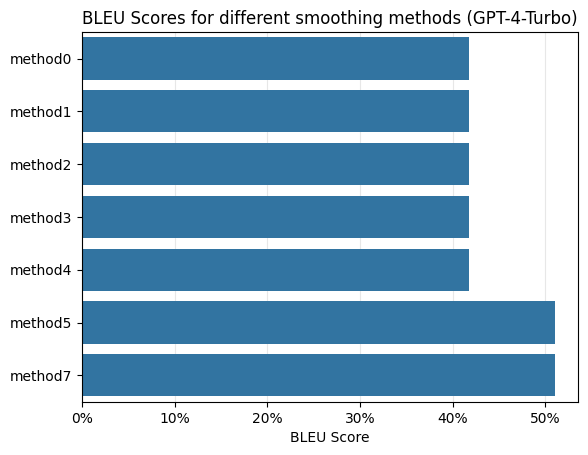

In [16]:
MODEL = 'gpt-4-turbo-2024-04-09'
scores = []
labels = []

for i in range(8):
    if i==6:
        continue
    try:
        score = calculate_bleu(alg[MODEL], normalize=False, smoothing_method=f"method{i}") 
        label = f"method{i}"
        scores.append(score)
        labels.append(label)
    except:
        pass
fig, ax = plot_bleu(scores, labels)
ax.set_title("BLEU Scores for different smoothing methods (GPT-4-Turbo)")

Methods 5 & 7 result in scors slightly above 50% but the paper reports BLEU scores of 57% using the Codex model.  It is possible that that model, being trained on code, was better at translating into Isabella.